<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/Probability_Calibration/02_Probability_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import warnings

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve)

from sklearn.model_selection import (
    train_test_split, GridSearchCV)

from sklearn.metrics import brier_score_loss, accuracy_score

from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

The objective of this exercise is to validate the model calibration process when the focus is on probabilities. A ensemble binary classification model will be applied. The methods 'CalibratedClassifierCV', 'calibration_curve' and 'brier_score_loss' will be used.

# **Settings**
---

In [54]:
random_seed=12345
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

# **Data**
---

Synthetic data will be generated

In [55]:
def data_generator(**kward):
  X, y = make_classification(
      random_state = random_seed,
      **kward
  )
  return X, y

# **Calibration**
---

## **Model, ensemble not Fitted**
---
- The model will be a 'ensemble' model and will not be trained. The model will is XGBoost

**Data**

A synthetic dataset of 8000 records will be generated, with 10 features, of which 8 will be informative and 2 will be redundant. It will be a binary classification dataset, with a classification error rate of 8% and a separation of 0.01. The dataset is designed to be challenging for the XGBoost model, as it is very powerful, which is why the configuration that allows for this was sought

In [56]:
X, y = data_generator(
    **{
      "n_samples":8000,
      "n_features":10,
      "n_informative":8,
      "n_redundant":2,
      "n_classes":2,
      "flip_y":0.08,
      "class_sep":0.01
      }
)

**Data Split**

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=random_seed
)

**Model**

A XGBClassifier is instantiated with basic configurations and without fit. The configuration is 800 estimators, a learning rate of 0.01, and a gbtree booster.

In [58]:
model_xgb = XGBClassifier(
    n_estimators = 800,
    learning_rate = 0.01,
    booster = "gbtree",
)

The model's probabilities are calibrated using the 'CalibratedClassifierCV' function with 10 'cv' and the 'isotonic' method.

In [59]:
calibrate_model_xgb = CalibratedClassifierCV(
    estimator=model_xgb,
    method='isotonic',
    cv=10,
    ensemble=True,
)
calibrate_model_xgb.fit(X_train, y_train)

CalibratedClassifierCV(cv=10,
                       estimator=XGBClassifier(base_score=None,
                                               booster='gbtree', callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.01, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=800, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       method='isotonic')

The test probabilities are obtained.

In [60]:
calibreated_probs_test = calibrate_model_xgb.predict_proba(X_test)

The previously configured, uncalibrated model is fitted. Then, probability predictions are made. This is done to compare the model's calibration


In [61]:
model_xgb.fit(X_train, y_train)

model_probs_test = model_xgb.predict_proba(X_test)

Having the probabilities, a comparison is made between the calibrated model and the fitted model.

It will be assumed that class 1 is the class of interest.

One class or another, the number of selected 'bins' may be smaller, as those with no probability will collapse. To get a good idea of how many groups can be obtained, a histogram is used to determine how many bins are suitable for grouping the average probabilities.

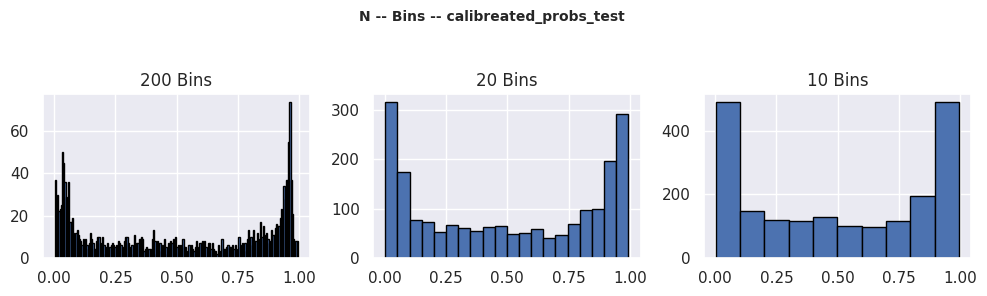

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(calibreated_probs_test[:,1], bins=200, edgecolor='black')
ax[0].set_title('200 Bins')

ax[1].hist(calibreated_probs_test[:,1], bins=20, edgecolor='black')
ax[1].set_title('20 Bins')
ax[2].hist(calibreated_probs_test[:,1], bins=10, edgecolor='black')
ax[2].set_title('10 Bins')
fig.tight_layout()
plt.subplots_adjust(top = 0.7)
fig.suptitle('N -- Bins -- calibreated_probs_test', fontsize = 10, fontweight = "bold");
plt.show()

- The number of 'bins' is set to 10, as a more accurate estimation can be obtained visually.

To be consistent with the visualization and comparison, the number 10 will be selected for the remaining functions to obtain a calibration curve.

In [67]:
prob_true_cali_target, prob_pred_cali_target = calibration_curve(y_test, calibreated_probs_test[:,1], n_bins=10)
prob_true_model_target, prob_pred_model_target = calibration_curve(y_test, model_probs_test[:,1], n_bins=10)


prob_true_cali_target_more_bins, prob_pred_cali_target_more_bins = calibration_curve(y_test, calibreated_probs_test[:,1], n_bins=10)
prob_true_model_target_more_bins, prob_pred_model_target_more_bins = calibration_curve(y_test, model_probs_test[:,1], n_bins=10)

The difference between the predicted probability and the actual outcome of the calibrated model is very close to zero, which means the model is reliable and making good predictions.

In [64]:
brier_score = brier_score_loss(y_test, calibreated_probs_test[:, 1])
brier_score

0.11852778925715637

However, the uncalibrated model also tends to be well-tuned, with the difference being minimal. This may suggest that it is not necessary to calibrate the model, with respect to the established configurations.

In [65]:
brier_score = brier_score_loss(y_test, model_probs_test[:, 1])
brier_score

0.128442497552773

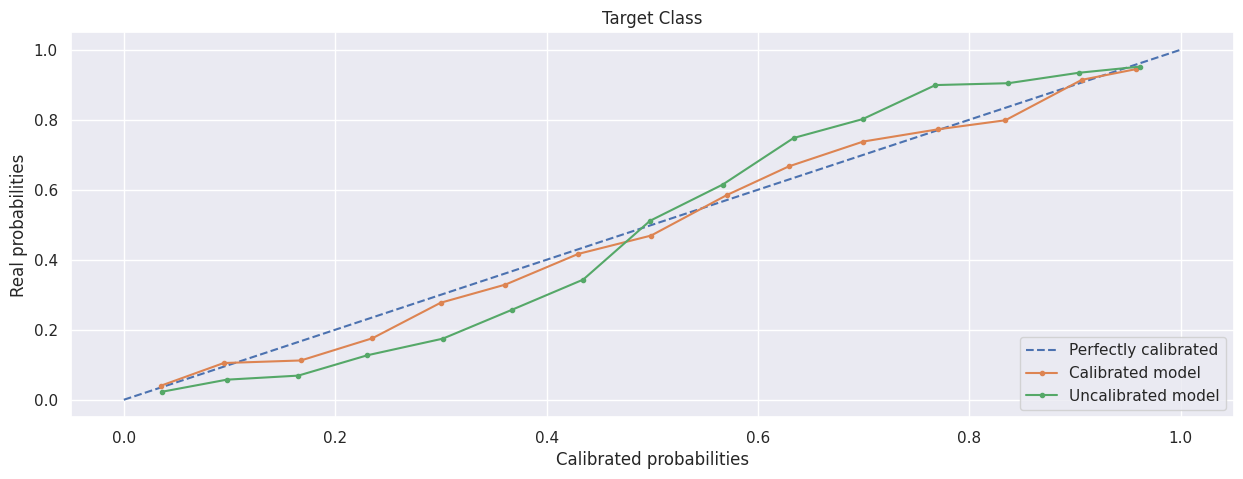

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred_cali_target, prob_true_cali_target, marker='.', label='Calibrated model')
plt.plot(prob_pred_model_target, prob_true_model_target, marker='.', label='Uncalibrated model')
plt.title("Target Class")
plt.legend(loc='lower right')
plt.xlabel('Calibrated probabilities')
plt.ylabel('Real probabilities')

plt.show()

For the next analysis, the most prominent probability points of each model will be examined.

# **Falta esta parte**
---

Since the dataset has a minimal imbalance, 'Accuracy' was used to validate performance. As mentioned earlier, the XGB model implementation is excellent for this type of problem and showed great performance, although the calibrated model has one more unit, which means its predictive ability improved. However, the difference is minimal.

In [72]:
accuracy_score(y_test, calibrate_model_xgb.predict(X_test))

0.8375

In [75]:
accuracy_score(y_test, model_xgb.predict(X_test))

0.8295